In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt


nlp =spacy.load(r'C:/Users/syful/Anaconda3/Lib/site-packages/en_core_web_sm/en_core_web_sm-2.2.5')

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


df = pd.read_csv("D:/1_NAIST_RESEARCH/SE_meeting/Ecommerce/06_Ecommerce_final_posts.csv")
print(df.Title.unique())
df.head()


# Convert to list
data = df.Title.values.tolist()


# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])


# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])


# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = en_core_web_sm.load('en', disable=['parser', 'ner'])
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Build LDA model
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Visualize the topics
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#vis

#pyLDAvis.save_html(vis, 'D:/1_NAIST_RESEARCH/SE_meeting/stackoverflow/lda.html')

C:\Users\syful\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


["What's the best online payment processing solution?"
 'Process raw HTTP request content'
 'Payment Processors - What do I need to know if I want to accept credit cards on my website?'
 ... 'PrestaShop 1.5 adding PHP (reCaptcha)'
 'Wordpress: How to submit a form from a rest api with a token'
 'Apache 2.4 mod_proxy_fcgi error on a PS 1.7.6.2']
['Whats the best online payment processing solution?']
[['whats', 'the', 'best', 'online', 'payment', 'processing', 'solution']]
['whats', 'the', 'best', 'online', 'payment', 'processing', 'solution']
[['s', 'good', 'online', 'payment', 'processing', 'solution']]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]
[(0,
  '0.526*"woocommerce" + 0.363*"product" + 0.024*"redirect" + 0.024*"return" + '
  '0.013*"discount" + 0.012*"apply" + 0.012*"tax" + 0.006*"version" + '
  '0.005*"module" + 0.004*"setting"'),
 (1,
  '0.569*"order" + 0.132*"make" + 0.103*"method" + 0.078*"search" + '
  '0.041*"sale" + 0.037*"ship" + 0.011*"s" + 0.003*"best_way" + 0.

In [4]:
import os
## Setup mallet environment change it according to your drive
os.environ.update({'MALLET_HOME':r'C:/mallet/'})
## Setup mallet path change it according to your drive
mallet_path = 'C:/mallet/bin/mallet'

## Train LDA with mallet
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=15, alpha=4, id2word=id2word,workers=4, prefix=None, optimize_interval=0, iterations=1000, topic_threshold=0.0, random_seed=0)
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [5]:
#pprint(ldamallet.show_topics(formatted=False))
print(ldamallet.print_topics(num_words=20))

[(0, '0.193*"order" + 0.081*"email" + 0.077*"woocommerce" + 0.053*"send" + 0.044*"customer" + 0.030*"status" + 0.026*"change" + 0.023*"create" + 0.021*"number" + 0.020*"detail" + 0.018*"invoice" + 0.017*"notification" + 0.015*"place" + 0.013*"complete" + 0.012*"mail" + 0.011*"update" + 0.011*"confirmation" + 0.010*"address" + 0.010*"template" + 0.009*"sale"'), (1, '0.097*"checkout" + 0.081*"woocommerce" + 0.077*"shipping" + 0.050*"method" + 0.031*"address" + 0.026*"base" + 0.022*"change" + 0.021*"set" + 0.020*"remove" + 0.020*"field" + 0.018*"ship" + 0.018*"page" + 0.017*"option" + 0.015*"hide" + 0.015*"country" + 0.014*"select" + 0.014*"disable" + 0.013*"payment" + 0.013*"specific" + 0.013*"default"'), (2, '0.080*"user" + 0.063*"form" + 0.041*"customer" + 0.035*"redirect" + 0.031*"page" + 0.023*"variable" + 0.021*"paypal" + 0.021*"datum" + 0.021*"pass" + 0.020*"log" + 0.020*"button" + 0.019*"session" + 0.019*"post" + 0.016*"return" + 0.016*"submit" + 0.015*"create" + 0.015*"account" +

In [6]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)



Coherence Score:  0.3866070607174959


In [7]:

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, alpha=int(50/num_topics)+1, id2word=id2word,workers=4, prefix=None, optimize_interval=0, iterations=1000, topic_threshold=0.0, random_seed=0)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [8]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=50, step=3)

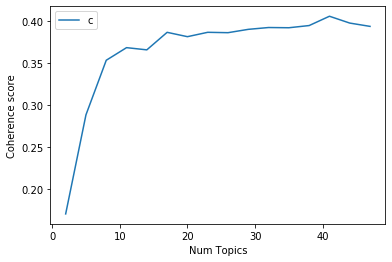

In [9]:
limit=50; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [10]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.17
Num Topics = 5  has Coherence Value of 0.288
Num Topics = 8  has Coherence Value of 0.353
Num Topics = 11  has Coherence Value of 0.368
Num Topics = 14  has Coherence Value of 0.3654
Num Topics = 17  has Coherence Value of 0.3863
Num Topics = 20  has Coherence Value of 0.3811
Num Topics = 23  has Coherence Value of 0.3863
Num Topics = 26  has Coherence Value of 0.3858
Num Topics = 29  has Coherence Value of 0.3898
Num Topics = 32  has Coherence Value of 0.392
Num Topics = 35  has Coherence Value of 0.3917
Num Topics = 38  has Coherence Value of 0.3943
Num Topics = 41  has Coherence Value of 0.4054
Num Topics = 44  has Coherence Value of 0.3973
Num Topics = 47  has Coherence Value of 0.3933


In [11]:
def compute_coherence_values_1(dictionary, corpus, texts, limit, start=14, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, alpha=int(44/num_topics)+1, id2word=id2word,workers=4, prefix=None, optimize_interval=0, iterations=1000, topic_threshold=0.0, random_seed=0)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
model_list, coherence_values_1 = compute_coherence_values_1(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=14, limit=44, step=1)

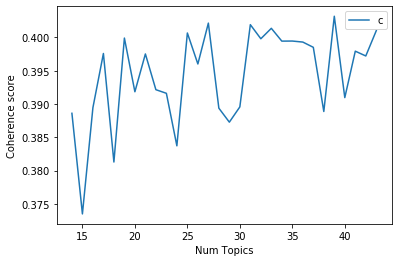

Num Topics = 14  has Coherence Value of 0.3886
Num Topics = 15  has Coherence Value of 0.3735
Num Topics = 16  has Coherence Value of 0.3894
Num Topics = 17  has Coherence Value of 0.3976
Num Topics = 18  has Coherence Value of 0.3813
Num Topics = 19  has Coherence Value of 0.3999
Num Topics = 20  has Coherence Value of 0.3918
Num Topics = 21  has Coherence Value of 0.3975
Num Topics = 22  has Coherence Value of 0.3921
Num Topics = 23  has Coherence Value of 0.3916
Num Topics = 24  has Coherence Value of 0.3837
Num Topics = 25  has Coherence Value of 0.4007
Num Topics = 26  has Coherence Value of 0.396
Num Topics = 27  has Coherence Value of 0.4021
Num Topics = 28  has Coherence Value of 0.3894
Num Topics = 29  has Coherence Value of 0.3873
Num Topics = 30  has Coherence Value of 0.3896
Num Topics = 31  has Coherence Value of 0.4019
Num Topics = 32  has Coherence Value of 0.3998
Num Topics = 33  has Coherence Value of 0.4014
Num Topics = 34  has Coherence Value of 0.3994
Num Topics = 3

In [12]:
limit=44; start=14; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values_1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values_1):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [13]:
print(model_list[13].print_topics(num_words=20))

[(1, '0.062*"variable" + 0.047*"return" + 0.046*"php" + 0.031*"pass" + 0.031*"array" + 0.029*"shopify" + 0.025*"object" + 0.024*"string" + 0.023*"function" + 0.019*"post" + 0.018*"liquid" + 0.018*"datum" + 0.015*"empty" + 0.014*"form" + 0.014*"work" + 0.013*"session" + 0.013*"statement" + 0.011*"url" + 0.010*"parameter" + 0.009*"convert"'), (3, '0.247*"product" + 0.067*"attribute" + 0.051*"option" + 0.042*"configurable" + 0.034*"add" + 0.032*"custom" + 0.032*"import" + 0.030*"create" + 0.028*"simple" + 0.026*"image" + 0.023*"show" + 0.020*"set" + 0.015*"csv" + 0.015*"price" + 0.015*"bundle" + 0.014*"group" + 0.013*"multiple" + 0.011*"frontend" + 0.010*"type" + 0.008*"export"'), (24, '0.125*"shipping" + 0.089*"woocommerce" + 0.062*"method" + 0.048*"checkout" + 0.039*"address" + 0.030*"base" + 0.027*"ship" + 0.022*"country" + 0.018*"field" + 0.017*"rate" + 0.017*"free" + 0.017*"cost" + 0.016*"payment" + 0.016*"change" + 0.015*"set" + 0.015*"delivery" + 0.014*"option" + 0.014*"remove" + 0

In [14]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model_list[13], corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.3439,"store, multiple, ecommerce, website, site, com...",Whats the best online payment processing solut...
1,1,1.0,0.2716,"variable, return, php, pass, array, shopify, o...",Process raw HTTP request content
2,2,8.0,0.6605,"payment, paypal, gateway, integration, adaptiv...",Payment Processors - What do I need to know if...
3,3,1.0,0.0988,"variable, return, php, pass, array, shopify, o...",Examples for coding against the PayPal API in ...
4,4,20.0,0.3642,"price, woocommerce, item, total, product, cart...",Credit card expiration dates - Inclusive or ex...
5,5,17.0,0.4568,"database, event, update, table, time, save, da...",Do I really need to use transactions in stored...
6,6,22.0,0.3210,"payment, paypal, account, sandbox, card, integ...",How to test credit card interactions?
7,7,0.0,0.1358,"spree, rail, model, override, work, find, clas...","Which should I implement first, PayPal or Goog..."
8,8,7.0,0.2469,"store, multiple, ecommerce, website, site, com...",Which PHP open source shopping cart solutions ...
9,9,1.0,0.2160,"variable, return, php, pass, array, shopify, o...",How do you detect Credit card type based on nu...


In [15]:
df_dominant_topic.to_csv('D:/1_NAIST_RESEARCH/SE_meeting/Ecommerce/RQ1_ecommerce_version_1.csv', header=True, index=False, encoding='utf-8') 


In [16]:
len(df_dominant_topic)

114949